# Dynamic MFA template (flow driven)

In [8]:
import pandas as pd
import numpy as np
import scipy.signal
import scipy.stats
import matplotlib.pyplot as plt

In [269]:
def diag_frame(frame): # to retain indeces when diagonalizing
    frame_diag = pd.DataFrame(np.diagflat(frame))
    frame_diag.index = frame_diag.columns = frame.index
    return frame_diag

def convolve_frame(frame, by, mode='full', boundary='fill', fillvalue=0, axis=0):
    if axis==0: frame = frame.T

    # perform convolution
    convolution = pd.DataFrame(scipy.signal.convolve2d(frame, by.reshape(1,-1), 
                                                       mode=mode,
                                                       boundary=boundary, 
                                                       fillvalue=fillvalue))
    # restore and extend indices from original frame
    convolution.columns += frame.columns[0]
    convolution.index = frame.index
    
    if axis==0: convolution=convolution.T
    return convolution

idx = pd.IndexSlice # facilitates easier multi-index slicing

# Wind energy on land
CBS provides a detailed dataset about wind-energy on land, which reports inflow, outflow and stock in terms of capacity, swept area and number of turbines. It also differentiates between turbines of five different height classes.

This dataset is used to answer the following questions:
1. what can be said about the stock & flow dynamics over time? (both total energy demand and turbine capacity are increasing steadily)
2. can blade diameter be approximated given only the turbine's capacity? (for the turbine sizes investigated, yes)
3. does blade mass per MW of capacity depend significantly on turbine size? (it does not, so methodology can safely be applied to offshore turbines)

In [547]:
# https://opendata.cbs.nl/#/CBS/nl/dataset/71227ned/table?dl=A7DAC
# https://www.cbs.nl/nl-nl/longread/aanvullende-statistische-diensten/2021/hernieuwbare-energie-in-nederland-2020/4-windenergie
datafile = 'Windenergie_op_land__productie_en_capaciteit_naar_ashoogte_15062024_113149.csv'
data = pd.read_csv(datafile,index_col=[0], header=[3,4],
                   sep=';', na_values='.').fillna(value=0)

# re-index with shorter, English column names
topic = ['amount','swept area','capacity']
info = ['inflow','outflow','stock']
h_hub = ['<30m','31m-50m','51m-70m','71m-95m','>96m']
data.columns = pd.MultiIndex.from_product([topic, info, h_hub], 
                                          names=['topic','stock/flow','hub height'])

# remove undesired rows and reformat data
data = data.drop(['Perioden', '2022**', '2023**', 'Bron: CBS'])
data = data.apply(pd.to_numeric)       # convert all data to numeric data type
data.index = pd.to_numeric(data.index) # convert indices to numeric data type
data.loc[:,idx['swept area',:,:]] *= 1000  # convert rotor area unit from '1000 m2' to 'm2'

## 1. Analysis of inflow & stock dynamics

<Axes: title={'center': 'land-based wind turbine stock composition (CBS, 2024)'}, xlabel='year', ylabel='installed capacity (MW)'>

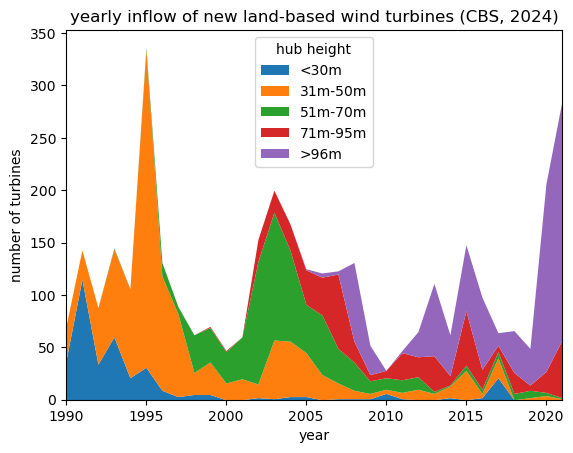

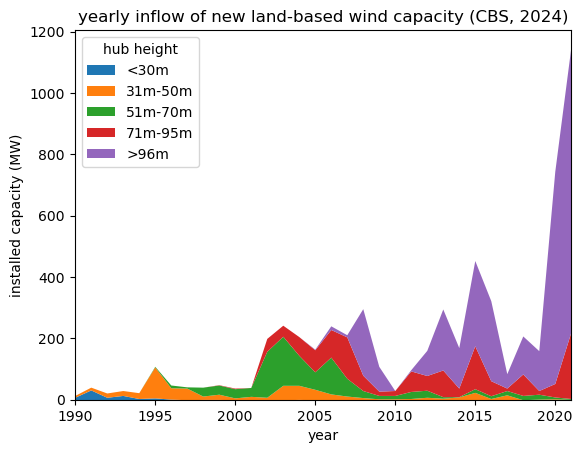

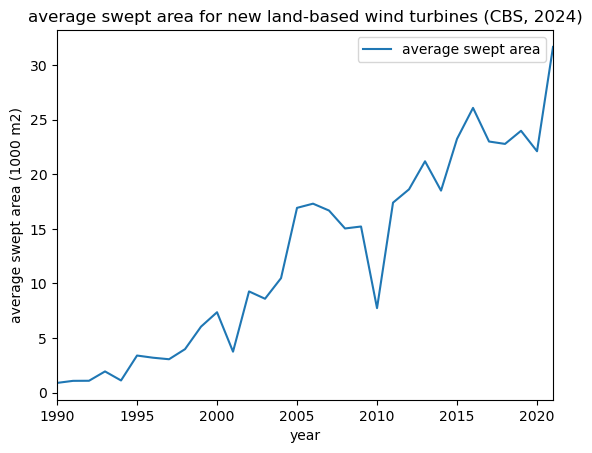

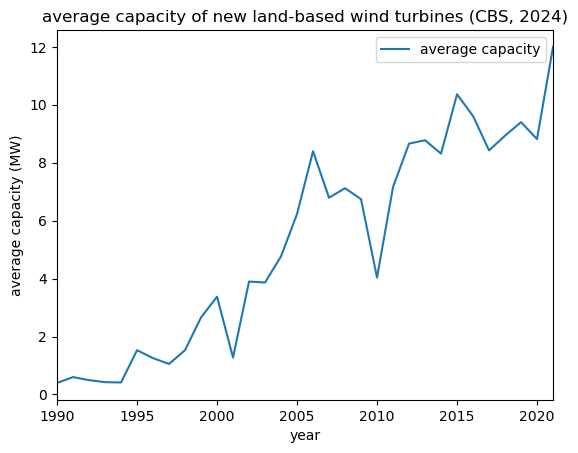

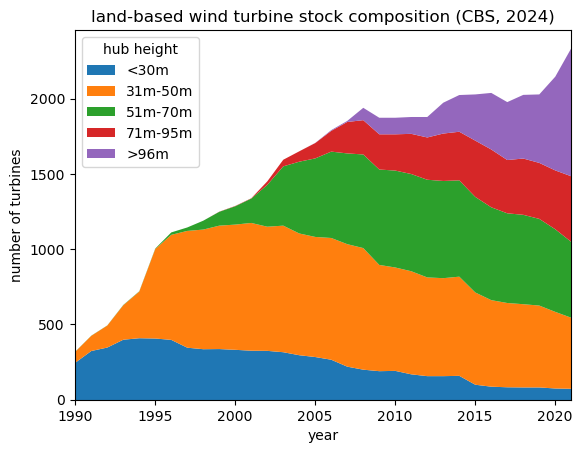

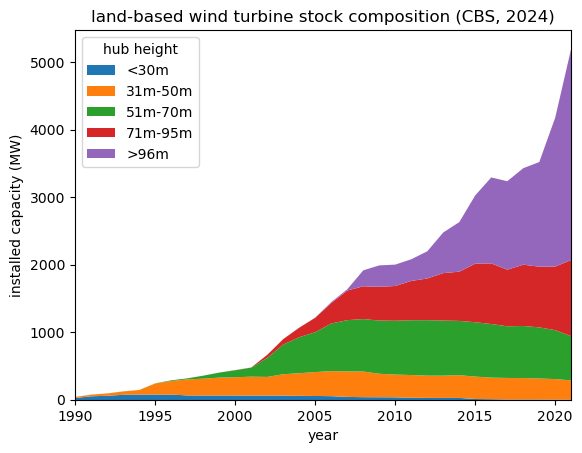

In [548]:
###############################
#           INFLOW
###############################
# extract inflow data (amount)
inflow = data.loc[:,idx['amount', 'inflow',:]]
inflow.columns = inflow.columns.droplevel(['topic', 'stock/flow']) # these columns provide no addititional information

# plot development over time
inflow.plot(kind='area',linewidth=0,xlim=[1990,2021],
            xlabel='year', ylabel='number of turbines',
            title='yearly inflow of new land-based wind turbines (CBS, 2024)')

# extract inflow data (capacity)
inflow_MW = data.loc[:,idx['capacity', 'inflow',:]]
inflow_MW.columns = inflow_MW.columns.droplevel(['topic', 'stock/flow']) # these columns provide no addititional information

# plot development over time
inflow_MW.plot(kind='area',linewidth=0,xlim=[1990,2021],
            xlabel='year', ylabel='installed capacity (MW)',
            title='yearly inflow of new land-based wind capacity (CBS, 2024)')

# calculate average swept area of newly installed turbines
avg_swept_area = pd.DataFrame((data.loc[:,idx['swept area', 'inflow', :]]/
                             data.loc[:,idx['amount', 'inflow', :]].values).fillna(0).sum(axis=1),
                           columns=['average swept area']) # plot would not show without converting to dataframe

# plot development over time
(avg_swept_area/1000).plot(xlim=[1990,2021],
                  xlabel='year', ylabel='average swept area (1000 m2)',
                  title='average swept area for new land-based wind turbines (CBS, 2024)')

# calculate average capacity of newly installed turbines
avg_capacity = pd.DataFrame((data.loc[:,idx['capacity', 'inflow', :]]/
                             data.loc[:,idx['amount', 'inflow', :]].values).fillna(0).sum(axis=1),
                           columns=['average capacity']) # plot would not show without converting to dataframe

# plot development over time
avg_capacity.plot(xlim=[1990,2021],
                  xlabel='year', ylabel='average capacity (MW)',
                  title='average capacity of new land-based wind turbines (CBS, 2024)')

###############################
#           STOCKS
###############################

# extract stock data (amount)
stock = data.loc[:,idx['amount', 'stock',:]]
stock.columns = stock.columns.droplevel(['topic', 'stock/flow']) # these columns provide no addititional information

# plot development over time
stock.plot(kind='area',linewidth=0,xlim=[1990,2021],
            xlabel='year', ylabel='number of turbines',
            title='land-based wind turbine stock composition (CBS, 2024)')

# extract stock data (capacity)
stock_MW = data.loc[:,idx['capacity', 'stock',:]]
stock_MW.columns = stock_MW.columns.droplevel(['topic', 'stock/flow']) # these columns provide no addititional information

# plot development over time
stock_MW.plot(kind='area',linewidth=0,xlim=[1990,2021],
            xlabel='year', ylabel='installed capacity (MW)',
            title='land-based wind turbine stock composition (CBS, 2024)')


It seems like the demand for land-based wind energy generation has been steadily increasing over the years. On the other hand, the amount of turbines neccecary to fill the required capacity as the turbines increase in size. That being the case, it seems reasonable to use installed capacity as the driving factor in a stock-driven model, and to assume a steady increase in per-turbine capacity.

## 2. Blade diameter approximation
#### Method A: from average swept area
Rotor diameter is calculated per hub-height category from average reported swept area.

In [549]:
# calculate average of reported swept area in/outflow
avg_swept_area = (data.loc[:,idx['swept area', ['inflow','outflow'], :]]/
                  data.loc[:,idx['amount', ['inflow','outflow'], :]].values).fillna(0)
avg_swept_area.columns = avg_swept_area.columns.droplevel('topic') # the topic is no longer 'rotor area' but 'avg rotor area'

# calculate average rotor diameter directly from swept rotor area
def area_to_diameter(area):
    diameter = np.sqrt(4*area/np.pi)
    return diameter
avg_diameter_a = avg_swept_area.map(area_to_diameter)

#### Method B: from average capacity
Rotor diameter is calculated based on a correlation between turbine capacity and blade diameter, as described by Li et al. (2022)
Using this route to calculate diameter eliminates the need to predict average swept area for future scenarios.

C:\Users\troyt\AppData\Local\Temp\ipykernel_4248\1871039470.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ax.plot(data.index.values, avg_diameter_a.groupby('stock/flow',axis=1).sum(),
C:\Users\troyt\AppData\Local\Temp\ipykernel_4248\1871039470.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ax.plot(data.index.values, avg_diameter_b.groupby('stock/flow',axis=1).sum(),
C:\Users\troyt\AppData\Local\Temp\ipykernel_4248\1871039470.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


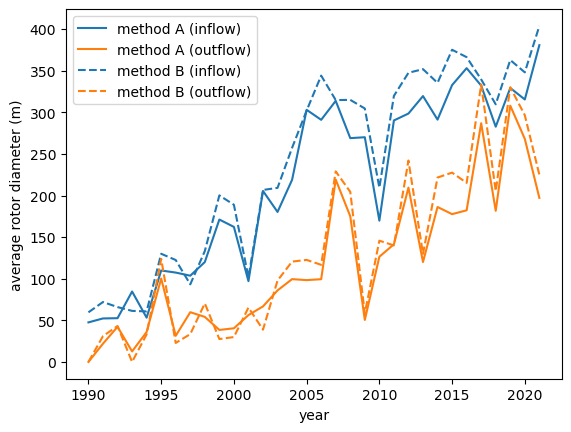

In [550]:
# calculate average capacity of inflows in MW
avg_capacity = (data.loc[:,idx['capacity', ['inflow','outflow'], :]]/
                data.loc[:,idx['amount', ['inflow','outflow'], :]].values).fillna(0)
avg_capacity.columns = avg_capacity.columns.droplevel('topic') # the topic is no longer 'capacity' but 'avg capacity'

# convert average capacity in MW into rotor diameter
def capacity_to_diameter(capacity):
    # accordign to Li et al. (2022) https://doi.org/10.1016/j.rser.2022.112603
    diameter = 62.69*np.power(capacity,0.46)
    return diameter
avg_diameter_b = avg_capacity.map(capacity_to_diameter)

# compare both methods in a single figure
fig, ax = plt.subplots()
ax.plot(data.index.values, avg_diameter_a.groupby('stock/flow',axis=1).sum(), 
        label=['method A (inflow)','method A (outflow)'])
plt.gca().set_prop_cycle(None) # reset color cycle
ax.plot(data.index.values, avg_diameter_b.groupby('stock/flow',axis=1).sum(), 
        label=['method B (inflow)','method B (outflow)'],
        linestyle='--')

# format plot area
ax.set_xlabel('year')
ax.set_ylabel('average rotor diameter (m)')
ax.legend()
fig.show()

# both methods yield similar results
# as method B requires less variables to calculate MI, it is used from now on
avg_diameter = avg_diameter_b

## 3. Material intensity estimation

max difference between per-category average overall average MI: 3.31%


C:\Users\troyt\AppData\Local\Temp\ipykernel_4248\952988760.py:11: RuntimeWarning: invalid value encountered in scalar divide
  MI = blade_mass/capacity # blade mass per MW for a turbine of given capacity


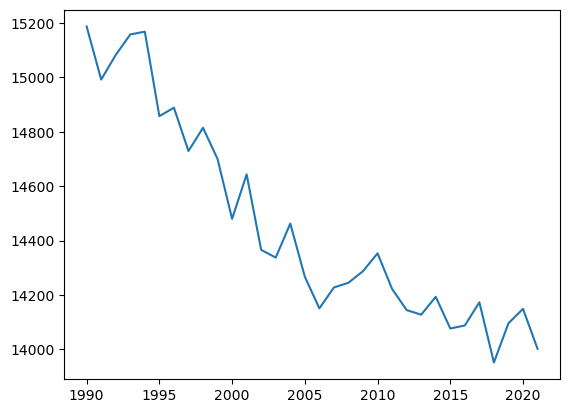

In [587]:
# convert rotor diameter into material stock
def diameter_to_mass(diameter, n_of_blades=3, material_intensity=1):
    # according to Crawford (2011) https://doi.org/10.24908/pceea.v0i0.3768 
    blade_mass = n_of_blades * 0.7911 * np.power(diameter,2.1055)
    return blade_mass * material_intensity

# convert turbine capacity to material intensity in kg/MW, taking the capacity route to estimate blade diameter
def capacity_to_MI(capacity):
    blade_diameter = capacity_to_diameter(capacity) # blade diameter corresponding to turbine of given capacity
    blade_mass = diameter_to_mass(blade_diameter)   # total blade mass for single turbine of given capacity
    MI = blade_mass/capacity # blade mass per MW for a turbine of given capacity
    return MI

# calculate average material intensity for each year and every height class
avg_inflow_MW = avg_capacity.loc[:,idx['inflow',:]]
avg_MI = avg_inflow_MW.map(capacity_to_MI)

# calculate maximum deviation between overall average material intensity and average material intensity per height class
MI = avg_MI.mean(axis=1)
MI.plot()
print(f'max difference between per-category average overall average MI: {np.max(abs(avg_MI.T-MI)/MI)*100:0.2f}%')

Material intensity is very similar between height classes.
To simplify the analyisis, no distinction shall be made between height classes from now on.

# Model
Things that affect stock dynamics of wind turbine blades
1. Demand for installed capacity (input variable)
2. Material intensity per MW (input variable, based on onshore wind)
3. Lifetime (input variable) (is this dependent on height class?)
   
4. Blade diameter (estimated using capacity)
5. Blade mass depending on diameter (Crawford, 2011)


In [602]:
# https://opendata.cbs.nl/statline/#/CBS/nl/dataset/82610NED/table?dl=A7DBD
datafile = 'Hernieuwbare_elektriciteit__productie_en_vermogen__15062024_182222.csv'
data = pd.read_csv(datafile,index_col=[0], header=[3,4],
                   sep=';', na_values='.').fillna(value=0)

# re-index with shorter, English column names
topic = ['amount','capacity']
location = ['onshore','offshore']
data.columns = pd.MultiIndex.from_product([topic, location], 
                                          names=['topic','location'])

# remove undesired rows and reformat data
data = data.drop(['Perioden', '2022**', '2023**', 'Bron: CBS'])
data = data.apply(pd.to_numeric)           # convert all data to numeric data type
data.index = pd.to_numeric(data.index)     # convert indices to numeric data type

In [604]:
# initialize model
past = data.index.values
future = np.arange(past[-1]+1, 2076)

years = np.concatenate([past, future])
model = pd.DataFrame(index=years)


# extract historical stock in MW
model.loc[past, 'stock'] = data.loc[:,idx['capacity',:]].sum(axis=1)

<Axes: title={'center': 'total installed capacity of land-based wind turbines'}, xlabel='year', ylabel='total capacity (MW)'>

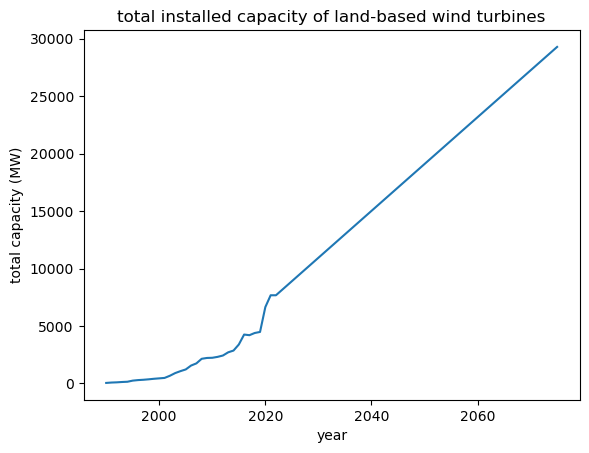

In [605]:
# create scenarios for future stock
present_stock = model.loc[past, 'stock'].iloc[-1]
model.loc[future, 'stock'] = present_stock+np.linspace(0, 400*len(future), len(future))

model.loc[:, 'stock'].plot(xlabel='year', ylabel='total capacity (MW)', 
                           title='total installed capacity of land-based wind turbines')

<Axes: title={'center': 'material intensity of wind_turbines'}, xlabel='year', ylabel='material intensity (kg/MW)'>

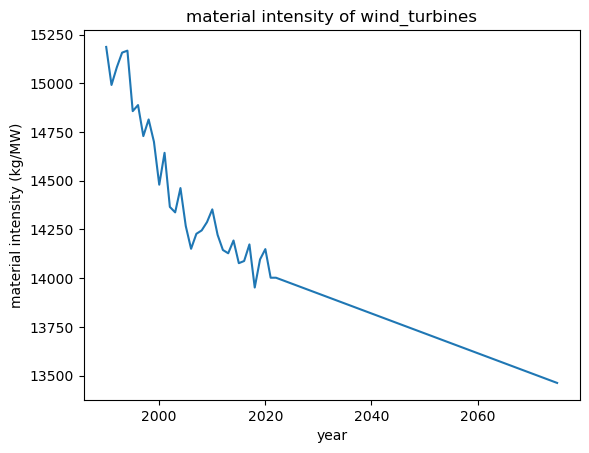

In [606]:

# extract historical capacity per turbine in MW
model.loc[past, 'MI'] = MI

# create scenarios for material intensity development
present_capacity = model.loc[past, 'MI'].iloc[-1]
model.loc[future, 'MI'] = present_capacity+np.linspace(0, -10*len(future), len(future))

model.loc[:, 'MI'].plot(xlabel='year', ylabel='material intensity (kg/MW)',
                        title='material intensity of wind_turbines')

In [607]:
model

,stock,MI
1990,50.000000,15186.942569
1991,83.000000,14991.748431
1992,101.000000,15082.269374
1993,131.000000,15157.668423
1994,152.000000,15167.880503
...,...,...
2071,27643.811321,13503.082098
2072,28051.358491,13492.893419
2073,28458.905660,13482.704740
2074,28866.452830,13472.516060


# outdated

In [545]:
# extract historical stock in MW
model.loc[past, 'stock'] = data.loc[:,idx['capacity','stock',:]].sum(axis=1) 

# extract historical capacity per turbine in MW
model.loc[past, 'avg capacity'] = (data.loc[:,idx['capacity','inflow']].sum(axis=1)/
                                   data.loc[:,idx['amount','inflow']].sum(axis=1))

# 

KeyError: 'stock'

<Axes: title={'center': 'total installed capacity of land-based wind turbines'}, xlabel='year', ylabel='total capacity (MW)'>

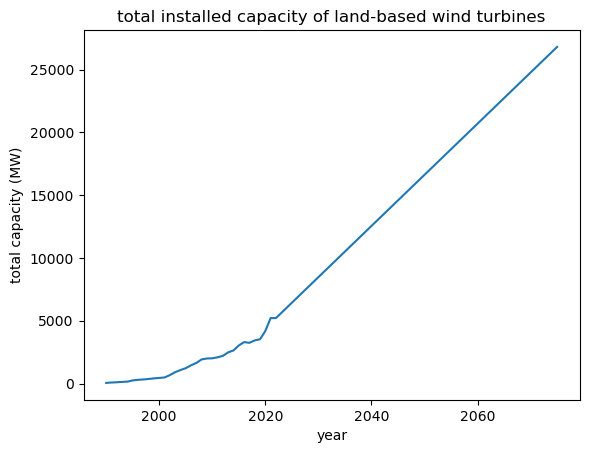

In [507]:
# create scenarios for future stock
present_stock = model.loc[past, 'stock'].iloc[-1]
model.loc[future, 'stock'] = present_stock+np.linspace(0, 400*len(future), len(future))

model.loc[:, 'stock'].plot(xlabel='year', ylabel='total capacity (MW)', 
                           title='total installed capacity of land-based wind turbines')

<Axes: title={'center': 'average capacity of new land-based wind turbines'}, xlabel='year', ylabel='average capacity (MW)'>

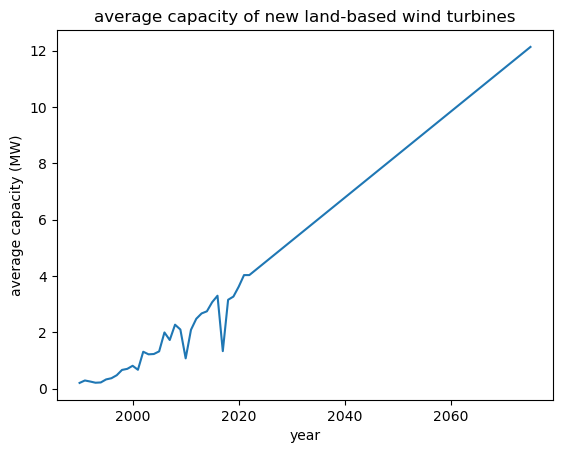

In [508]:
# create scenarios for future capacity
present_capacity = model.loc[past, 'avg capacity'].iloc[-1]
model.loc[future, 'avg capacity'] = present_capacity+np.linspace(0, 0.15*len(future), len(future))

model.loc[:, 'avg capacity'].plot(xlabel='year', ylabel='average capacity (MW)',
                                  title='average capacity of new land-based wind turbines')

#### 2. Define survival curve
Examples of often-used survival functions
- fixed lifetime (make manually)
- weibull        (scipy.stats.weibull_min)
- normal         (scipy.stats.norm)
- geometric      (scipy.stats.geom)
- uniform        (scipy.stats.uniform)
- lognormal      (scipy.stats.lognorm)

In [539]:
# define lifetime function 
# normally distributed survival curve
curve_mean = 20
curve_sd = 2
curve_years = np.arange(0, int(curve_mean+6*curve_sd))

lifetime_curve = scipy.stats.norm.pdf(curve_years, loc=curve_mean, scale=curve_sd)
survival_curve = scipy.stats.norm.sf(curve_years, loc=curve_mean, scale=curve_sd)

## Execute model

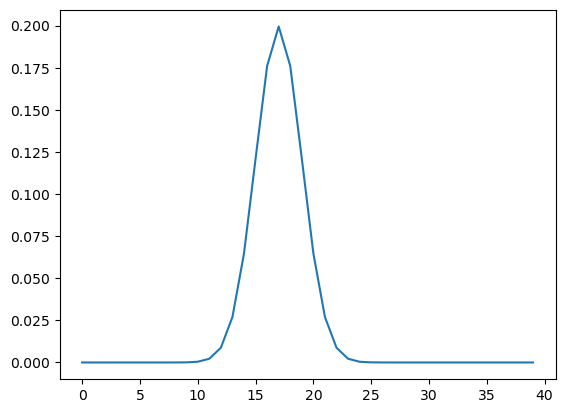

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['51m-70m', '71m-95m', '>96m']

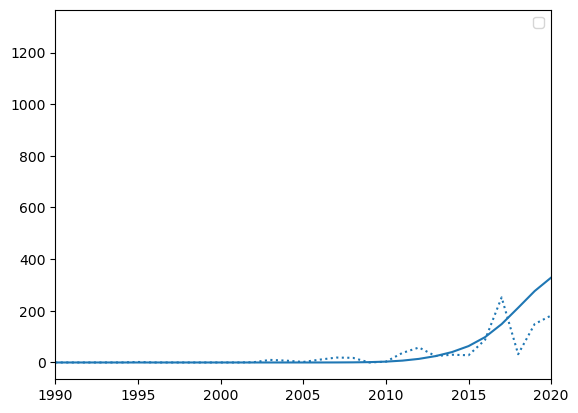

In [310]:
# create inflow matrix
inflow = data.loc[:,idx['rotor area', 'inflow', h_hub[2:]]]/1000
#inflow.columns = inflow.columns.droplevel([0,1])

# calculate outflow
outflow = convolve_frame(inflow, lifetime_curve).sum(axis=1)

# create outflow matrix from reported outflows
outflow_reported = data.loc[:,idx['rotor area', 'outflow', h_hub[2:]]].sum(axis=1)/1000
#outflow_reported.columns = outflow_reported.columns.droplevel([0,1])

# plot stuff
fig, ax = plt.subplots()
ax.plot(outflow_reported.index, outflow_reported, linestyle = ':')
plt.gca().set_prop_cycle(None) # reset color cycle
ax.plot(outflow.index, outflow)
ax.set_xlim([1990,2020])
#ax.set_ylim([0,100])
ax.legend()


In [238]:
lifetime_curve = pd.DataFrame(index=years, columns=h_hub)
survival_curve = pd.DataFrame(index=years, columns=h_hub)
for hub_height in h_hub:
    
survival_curve.iloc[,:] = scipy.stats.norm.sf(years,loc=curve_mean, scale=curve_sd)
lifetime_curve.iloc[,:] = scipy.stats.norm.pdf(years,loc=curve_mean, scale=curve_sd)

plt.plot(lifetime_curve)
plt.show()



# (increases linearly over time?)
# (depends on windmill diameter?)

# apply lifetime function to inflows
# (does it match outflows in CBS data?)

survival_curve

IndentationError: expected an indented block after 'for' statement on line 3 (1155131396.py, line 5)